# **GPU Information**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Mon Aug 15 00:20:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Packages**

In [1]:
import torch
import torchvision
import time
import math
import copy
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal


%matplotlib inline

# **Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **FashionMNIST Dataset**

In [ ]:
fmnist_trainset = torchvision.datasets.FashionMNIST('./fmnist/', train=True, download=True, 
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(), 
                                       ]))

fmnist_trainset, fmnist_valset = torch.utils.data.random_split(fmnist_trainset, [50000, 10000])

fmnist_testset = torchvision.datasets.FashionMNIST('./fmnist/', train=False, download=True, 
                                  transform=torchvision.transforms.Compose([ 
                                      torchvision.transforms.ToTensor(),  
                                      ]))

fmnist_train_loader = torch.utils.data.DataLoader(fmnist_trainset, batch_size=100, shuffle=True)

fmnist_val_loader = torch.utils.data.DataLoader(fmnist_valset, batch_size=100, shuffle=True)

fmnist_test_loader = torch.utils.data.DataLoader(fmnist_testset, batch_size=100, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



# **Bayesian Modules**

In [ ]:
class Gaussian():
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()
    
    
class ScaleMixtureGaussian():
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = Normal(0,sigma1)
        self.gaussian2 = Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()
    
    


class GuassianLinear(nn.Module):
    
    def __init__(self,
                 in_features, 
                 out_features, 
                 PI = 0.5, 
                 SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), 
                 SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))):
        
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input_data, sample=True, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input_data, weight, bias)
    
    
class GuassianConvolution2D(nn.Module):
    
    def __init__(self, 
                 in_features, 
                 out_features, 
                 kernel_size,
                 stride = 1, 
                 padding = 0, 
                 dilation = 1,
                 PI = 0.5, 
                 SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")),  
                 SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))):
        
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation =dilation
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features, self.kernel_size, self.kernel_size).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features, self.kernel_size, self.kernel_size).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0
        
    def forward(self, input_data, sample=True, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.conv2d(input_data, weight, bias, stride = self.stride, padding = self.padding, dilation = self.dilation)

# **Bayesian LeNet5**

In [ ]:
class BayesianLeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GuassianConvolution2D(1, 16, 5)
        self.conv2 = GuassianConvolution2D(16, 32, 5)
        self.linear1 = GuassianLinear(512, 128)
        self.linear2 = GuassianLinear(128, 10)
    
    def forward(self, x, sample=True):
        out = self.conv1(x, sample)
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        out = F.relu(out)
        
        out = self.conv2(out, sample)
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        out = F.relu(out)
        
        out = out.view(-1, 512)
        
        out = self.linear1(out, sample)
        out = F.relu(out)
        
        out = self.linear2(out, sample)
        output = F.log_softmax(out, dim = -1)
        return output
    
    def log_prior(self):
        return self.conv1.log_prior \
               + self.conv2.log_prior \
               + self.linear1.log_prior \
               + self.linear2.log_prior
    
    def log_variational_posterior(self):
        return self.conv1.log_variational_posterior \
               + self.conv2.log_variational_posterior \
               + self.linear1.log_variational_posterior \
               + self.linear2.log_variational_posterior
    
    def sample_elbo(self, 
                    x, 
                    target, 
                    BATCH_SIZE, 
                    NUM_BATCHES, 
                    samples = 2, 
                    CLASSES = 10, 
                    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
        
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_variational_posteriors = torch.zeros(samples).to(device)
        
        for i in range(samples):
            outputs[i] = self(x, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction='sum')
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

# **Fast Geometric Ensembling**

**Define Pre-training Process**

In [ ]:
def BayesianLeNet5training(train_loader, val_loader, nepochs, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 

    model = BayesianLeNet5().to(device)
    model.train()
            
    optimizer = torch.optim.SGD(model.parameters(), lr = 4e-3)
    optimizer.zero_grad()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = nepochs, eta_min= 1e-4)

    if track: 
        Loss = []
        Acc = []
        LR = []

    batchLen = len(train_loader)
    nval = len(val_loader) * nbatch
    digitsBatchLen = len(str(batchLen))
    
    for n in np.arange(nepochs): 
        
        if track: 

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

        for batch_id, sample in enumerate(train_loader):
                    
            images, labels = sample
            images, labels = images.to(device), labels.to(device)
                    
            loss, log_prior, log_variational_posterior, negative_log_likelihood = model.sample_elbo(images, labels, BATCH_SIZE = nbatch, NUM_BATCHES = batchLen)
                    
            optimizer.zero_grad()
            loss.backward()
                    
            optimizer.step()
                    
            if track: 

                Loss.append(loss.detach().cpu().item())
                    
            print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                      n+1, nepochs,
                                                      batch_id+1,
                                                      batchLen, 
                                                      loss.detach().cpu().item()), 
                        end="")
        print("")

        if track: 

            LR.append(scheduler.get_last_lr())

        scheduler.step()

        if ((n == nepochs - 1) and track): 

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

    if track:
        
        return model, Loss, Acc, LR

    else: 
        return model

**Define FGE Training Process**

In [ ]:
def FGE_BayesianLeNet5training(train_loader, val_loader, nepochs, nmodels, pretrained_model, pretrained_Loss, pretrained_Acc, pretrained_LR, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 

    Models = {}
    model = pretrained_model
    model.train()
            
    optimizer = torch.optim.SGD(model.parameters(), lr = 4e-3)
    optimizer.zero_grad()

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 1e-4, max_lr = 4e-3, step_size_up= nepochs/2)

    if track: 
        Loss = pretrained_Loss
        Acc = pretrained_Acc
        LR = pretrained_LR

    batchLen = len(train_loader)
    nval = len(val_loader) * nbatch
    digitsBatchLen = len(str(batchLen))
    
    for n in np.arange(nepochs * nmodels): 

        for batch_id, sample in enumerate(train_loader):
                    
            images, labels = sample
            images, labels = images.to(device), labels.to(device)
                    
            loss, log_prior, log_variational_posterior, negative_log_likelihood = model.sample_elbo(images, labels, BATCH_SIZE = nbatch, NUM_BATCHES = batchLen)
                    
            optimizer.zero_grad()
            loss.backward()
                    
            optimizer.step()
                    
            if track: 

                Loss.append(loss.detach().cpu().item())
                    
            print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                      n+1, nepochs * nmodels,
                                                      batch_id+1,
                                                      batchLen, 
                                                      loss.detach().cpu().item()), 
                        end="")
        print("")

        if track: 

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

            LR.append(scheduler.get_last_lr())

        scheduler.step()

        if n % nepochs == 0:

            torch.save(model.state_dict(), 'model {}.pth'.format(int(n / nepochs)))

            stored_model = BayesianLeNet5().to(device)

            stored_model.load_state_dict(torch.load('model {}.pth'.format(int(n / nepochs))))

            Models[int(n / nepochs)] = stored_model

            print("\n========================================================")

            print("model {} is saved into ensemble".format(int(n / nepochs) + 1))

            print("{} model(s) has been saved".format(len(Models)))

            print("========================================================\n")

    if track:
        
        return Models, Loss, Acc, LR

    else: 
        return Models

**Pre-train a Model**

In [ ]:
pretrained_Lemodel, pretrained_LeLoss, pretrained_LeAcc, pretrained_LeLR = BayesianLeNet5training(train_loader = fmnist_train_loader, 
                                                    val_loader = fmnist_val_loader, 
                                                    nepochs = 30, 
                                                    track = True)


Accuracy on Validation Set: 900.0/10000 (9.0000%)

--------------------------------------------------------
 	Epoch 1/30: Train step 500/500 loss = 716.1016

Accuracy on Validation Set: 8322.0/10000 (83.2200%)

--------------------------------------------------------
 	Epoch 2/30: Train step 500/500 loss = 711.9620

Accuracy on Validation Set: 8469.0/10000 (84.6900%)

--------------------------------------------------------
 	Epoch 3/30: Train step 500/500 loss = 701.1388

Accuracy on Validation Set: 8626.0/10000 (86.2600%)

--------------------------------------------------------
 	Epoch 4/30: Train step 500/500 loss = 692.4846

Accuracy on Validation Set: 8669.0/10000 (86.6900%)

--------------------------------------------------------
 	Epoch 5/30: Train step 500/500 loss = 690.7892

Accuracy on Validation Set: 8618.0/10000 (86.1800%)

--------------------------------------------------------
 	Epoch 6/30: Train step 500/500 loss = 684.1119

Accuracy on Validation Set: 8834.0/10000 

**FGE Training**

In [ ]:
FGE_Models, FGE_Loss, FGE_Acc, FGE_LR = FGE_BayesianLeNet5training(train_loader = fmnist_train_loader, 
                                    val_loader = fmnist_val_loader, 
                                    nepochs = 8, 
                                    nmodels = 10, 
                                    pretrained_model = pretrained_Lemodel, 
                                    pretrained_Loss = pretrained_LeLoss, 
                                    pretrained_Acc = pretrained_LeAcc, 
                                    pretrained_LR = pretrained_LeLR, 
                                    nbatch = 100, 
                                    track = True)

 	Epoch 1/80: Train step 500/500 loss = 604.1110

Accuracy on Validation Set: 8969.0/10000 (89.6900%)

--------------------------------------------------------

model 1 is saved into ensemble
1 model(s) has been saved

 	Epoch 2/80: Train step 500/500 loss = 700.4825

Accuracy on Validation Set: 8667.0/10000 (86.6700%)

--------------------------------------------------------
 	Epoch 3/80: Train step 500/500 loss = 760.5890

Accuracy on Validation Set: 8732.0/10000 (87.3200%)

--------------------------------------------------------
 	Epoch 4/80: Train step 500/500 loss = 781.7491

Accuracy on Validation Set: 8330.0/10000 (83.3000%)

--------------------------------------------------------
 	Epoch 5/80: Train step 500/500 loss = 781.2891

Accuracy on Validation Set: 8445.0/10000 (84.4500%)

--------------------------------------------------------
 	Epoch 6/80: Train step 500/500 loss = 758.5243

Accuracy on Validation Set: 8562.0/10000 (85.6200%)

--------------------------------------

**Accuracy on Validation Set**

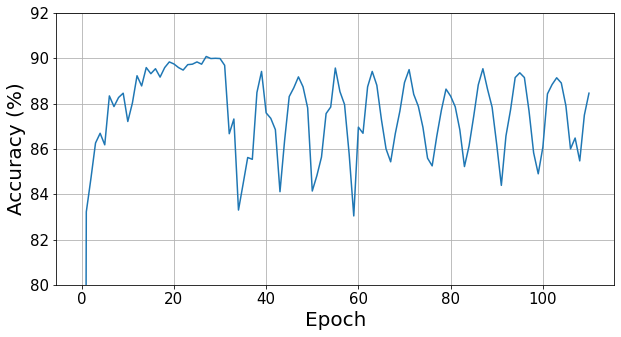

In [ ]:
fs = 20
FGE_Acc_fig = plt.figure(figsize=(10,5))
plt.plot(FGE_Acc)
plt.grid()
plt.ylim(80,92)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
#plt.legend()
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
FGE_Acc_fig.savefig("FGE_Acc_fig.png")

**Loss on Trainset**

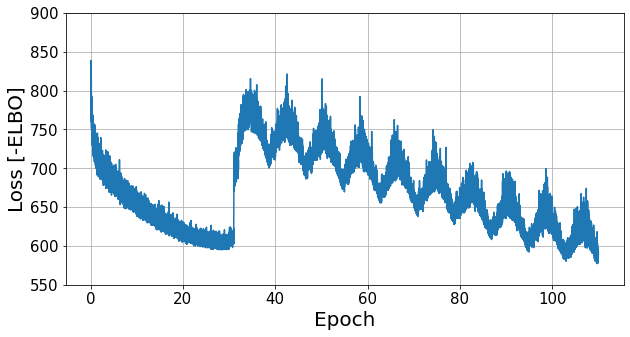

In [ ]:
fs = 20
FGE_Loss_fig = plt.figure(figsize=(10,5))
x = np.arange(len(FGE_Loss))[50:] / 500.
plt.plot(x, FGE_Loss[50:])
plt.grid()
plt.ylim(550,900)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss [-ELBO]',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
FGE_Loss_fig.savefig("FGE_Loss_fig.png")

**Learning Rate Schedule**

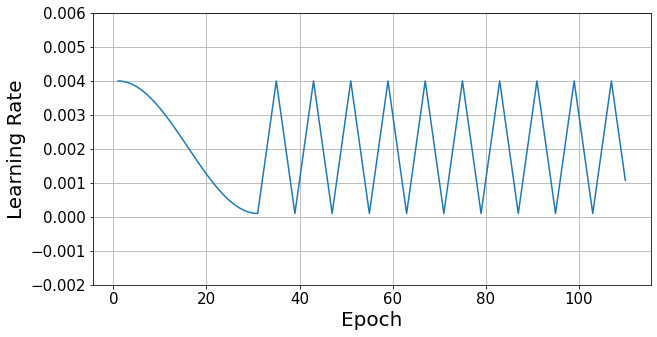

In [ ]:
fs = 20
FGE_LR_fig = plt.figure(figsize=(10,5))
x = np.arange(len(FGE_LR)) + 1
plt.plot(x, FGE_LR)
plt.grid()
plt.ylim(-0.002,0.006)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Learning Rate',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
FGE_LR_fig.savefig("FGE_LR_fig.png")

**Calculate Training Time**

In [ ]:
FGE_Letraining_start = time.time()

%time pretrained_Lemodel = BayesianLeNet5training(train_loader = fmnist_train_loader, val_loader = fmnist_val_loader, nepochs = 30, track = False)

%time FGE_Models = FGE_BayesianLeNet5training(train_loader = fmnist_train_loader, val_loader = fmnist_val_loader, nepochs = 8, nmodels = 10, pretrained_model = pretrained_Lemodel, pretrained_Loss = None, pretrained_Acc = None, pretrained_LR = None, nbatch = 100, track = False)

FGE_Letraining_end = time.time()

FGE_Letraining_time = FGE_Letraining_end - FGE_Letraining_start

print(FGE_Letraining_time)

 	Epoch 1/30: Train step 500/500 loss = 730.6539
 	Epoch 2/30: Train step 500/500 loss = 714.0973
 	Epoch 3/30: Train step 500/500 loss = 709.2722
 	Epoch 4/30: Train step 500/500 loss = 716.6675
 	Epoch 5/30: Train step 500/500 loss = 692.7570
 	Epoch 6/30: Train step 500/500 loss = 688.5512
 	Epoch 7/30: Train step 500/500 loss = 678.1079
 	Epoch 8/30: Train step 500/500 loss = 682.2467
 	Epoch 9/30: Train step 500/500 loss = 673.3846
 	Epoch 10/30: Train step 500/500 loss = 687.2477
 	Epoch 11/30: Train step 500/500 loss = 662.6052
 	Epoch 12/30: Train step 500/500 loss = 670.6644
 	Epoch 13/30: Train step 500/500 loss = 658.7331
 	Epoch 14/30: Train step 500/500 loss = 660.1747
 	Epoch 15/30: Train step 500/500 loss = 660.0149
 	Epoch 16/30: Train step 500/500 loss = 654.1923
 	Epoch 17/30: Train step 500/500 loss = 640.4695
 	Epoch 18/30: Train step 500/500 loss = 635.8014
 	Epoch 19/30: Train step 500/500 loss = 640.1805
 	Epoch 20/30: Train step 500/500 loss = 636.2321
 	Epoch 2

In [ ]:
np.save('./FGE_Letraining_time.npy', FGE_Letraining_time)

**Accuracy on Testset**

In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10
nmodels = 10

with torch.no_grad(): 

    correct = 0

    for batch_id, sample in enumerate(fmnist_test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            model_num = np.random.randint(nmodels)
            model = FGE_Models[model_num]

            model.to(device)
            model.eval()

            pred = model(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(fmnist_testset), correct/len(fmnist_testset) * 100.))
    
    FGE_Ens_Leacc = correct/len(fmnist_testset) * 100.


Accuracy on Test Set: 8976.0/10000 (89.7600%)



In [ ]:
np.save('./FGE_Ens_Leacc.npy', FGE_Ens_Leacc)

# **Stochastic Weight Averaging**

**Define SWA Training Process**

In [ ]:
def SWA_BayesianLeNet5training(train_loader, val_loader, nepochs, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 

    model = BayesianLeNet5().to(device)
    model.train()
            
    optimizer = torch.optim.SGD(model.parameters(), lr = 4e-3)
    optimizer.zero_grad()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = nepochs, eta_min= 1e-4)

    swa_model = torch.optim.swa_utils.AveragedModel(model)
    swa_start = 15
    swa_scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_epochs=5, swa_lr = 6e-3)

    if track: 
        Loss = []
        Acc = []
        LR = []

    batchLen = len(train_loader)
    nval = len(val_loader) * nbatch
    digitsBatchLen = len(str(batchLen))
    
    for n in np.arange(nepochs): 
        
        if track: 

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = swa_model(images) if n >= (swa_start + 1) else model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

        for batch_id, sample in enumerate(train_loader):
                    
            images, labels = sample
            images, labels = images.to(device), labels.to(device)
                    
            loss, log_prior, log_variational_posterior, negative_log_likelihood = model.sample_elbo(images, labels, BATCH_SIZE = nbatch, NUM_BATCHES = batchLen)
                    
            optimizer.zero_grad()
            loss.backward()
                    
            optimizer.step()
                    
            if track: 

                Loss.append(loss.detach().cpu().item())
                    
            print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                      n+1, nepochs,
                                                      batch_id+1,
                                                      batchLen, 
                                                      loss.detach().cpu().item()), 
                        end="")
        print("")

        if n >= swa_start:

            swa_model.update_parameters(model)
            swa_scheduler.step()

            if track: 
              
                LR.append(swa_scheduler.get_last_lr())

        else:

            if track: 

                LR.append(scheduler.get_last_lr())

            scheduler.step()

        if ((n == nepochs - 1) and track):

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = swa_model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

    if track:
        
        return swa_model, Loss, Acc, LR

    else: 
        return swa_model

**SWA Training**

In [ ]:
SWA_model, SWA_Loss, SWA_Acc, SWA_LR = SWA_BayesianLeNet5training(train_loader = fmnist_train_loader, val_loader = fmnist_val_loader, nepochs = 30, nbatch = 100, track = True)


Accuracy on Validation Set: 1109.0/10000 (11.0900%)

--------------------------------------------------------
 	Epoch 1/30: Train step 500/500 loss = 727.9039

Accuracy on Validation Set: 8084.0/10000 (80.8400%)

--------------------------------------------------------
 	Epoch 2/30: Train step 500/500 loss = 713.8918

Accuracy on Validation Set: 8530.0/10000 (85.3000%)

--------------------------------------------------------
 	Epoch 3/30: Train step 500/500 loss = 699.4948

Accuracy on Validation Set: 8565.0/10000 (85.6500%)

--------------------------------------------------------
 	Epoch 4/30: Train step 500/500 loss = 692.7079

Accuracy on Validation Set: 8699.0/10000 (86.9900%)

--------------------------------------------------------
 	Epoch 5/30: Train step 500/500 loss = 692.5867

Accuracy on Validation Set: 8666.0/10000 (86.6600%)

--------------------------------------------------------
 	Epoch 6/30: Train step 500/500 loss = 677.8027

Accuracy on Validation Set: 8698.0/1000

**Training Accuracy on Validation Set**

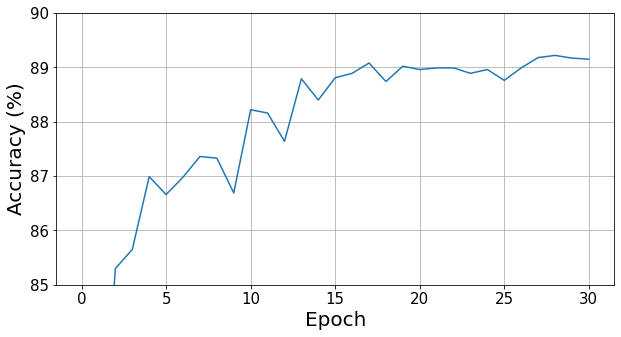

In [ ]:
fs = 20
SWA_Acc_fig = plt.figure(figsize=(10,5))
plt.plot(SWA_Acc)
plt.grid()
plt.ylim(85,90)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
SWA_Acc_fig.savefig("SWA_Acc_fig.png")

**Training Loss on Trainset**

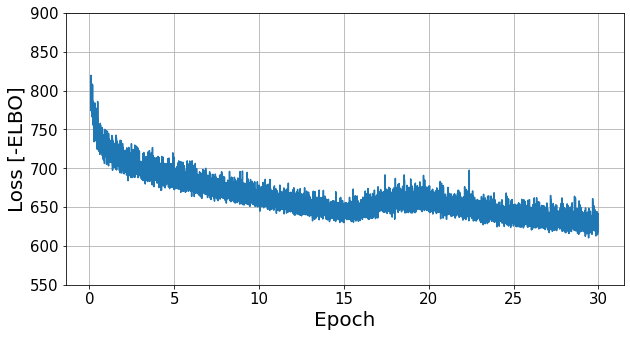

In [ ]:
fs = 20
SWA_Loss_fig = plt.figure(figsize=(10,5))
x = np.arange(len(SWA_Loss))[50:] / 500.
plt.plot(x, SWA_Loss[50:])
plt.grid()
plt.ylim(550,900)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss [-ELBO]',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
SWA_Loss_fig.savefig("SWA_Loss_fig.png")

**Learning Rate Schedule**

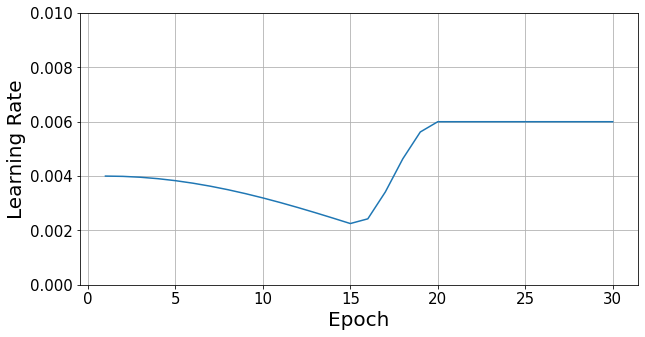

In [ ]:
fs = 20
SWA_LR_fig = plt.figure(figsize=(10,5))
x = np.arange(len(SWA_LR)) + 1
plt.plot(x, SWA_LR)
plt.grid()
plt.ylim(-0.000,0.010)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Learning Rate',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
SWA_LR_fig.savefig("SWA_LR_fig.png")

**Calculate Training Time**

In [ ]:
SWA_Letraining_start = time.time()

%time SWA_model = SWA_BayesianLeNet5training(train_loader = fmnist_train_loader, val_loader = fmnist_val_loader, nepochs = 30, nbatch = 100, track = False)

SWA_Letraining_end = time.time()

SWA_Letraining_time = SWA_Letraining_end - SWA_Letraining_start

print(SWA_Letraining_time)

 	Epoch 1/30: Train step 500/500 loss = 712.9701
 	Epoch 2/30: Train step 500/500 loss = 700.4148
 	Epoch 3/30: Train step 500/500 loss = 685.2609
 	Epoch 4/30: Train step 500/500 loss = 685.3839
 	Epoch 5/30: Train step 500/500 loss = 678.0294
 	Epoch 6/30: Train step 500/500 loss = 691.6199
 	Epoch 7/30: Train step 500/500 loss = 673.5267
 	Epoch 8/30: Train step 500/500 loss = 665.1724
 	Epoch 9/30: Train step 500/500 loss = 654.3007
 	Epoch 10/30: Train step 500/500 loss = 649.1824
 	Epoch 11/30: Train step 500/500 loss = 647.6579
 	Epoch 12/30: Train step 500/500 loss = 646.1798
 	Epoch 13/30: Train step 500/500 loss = 637.2963
 	Epoch 14/30: Train step 500/500 loss = 636.3509
 	Epoch 15/30: Train step 500/500 loss = 638.0976
 	Epoch 16/30: Train step 500/500 loss = 638.2518
 	Epoch 17/30: Train step 500/500 loss = 635.0547
 	Epoch 18/30: Train step 500/500 loss = 650.7488
 	Epoch 19/30: Train step 500/500 loss = 647.2278
 	Epoch 20/30: Train step 500/500 loss = 644.0886
 	Epoch 2

In [ ]:
np.save('./SWA_Letraining_time.npy', SWA_Letraining_time)

**Accuracy on Test Set**

In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10

with torch.no_grad(): 

    SWA_model.to(device)
    SWA_model.eval()

    correct = 0

    for batch_id, sample in enumerate(fmnist_test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            pred = SWA_model(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
        correct, len(fmnist_testset), correct/len(fmnist_testset) * 100.))
    
    SWA_Ens_Leacc = correct/len(fmnist_testset) * 100.


Accuracy on Test Set: 8977.0/10000 (89.7700%)



In [ ]:
np.save('./SWA_Ens_Leacc.npy', SWA_Ens_Leacc)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Training Time Comparison**

In [4]:
Letraining_time = np.load('/content/drive/MyDrive/FGE + SWA/Letraining_time.npy', allow_pickle=True).item()
Ens_Letraining_time = np.load('/content/drive/MyDrive/FGE + SWA/Ens_Letraining_time.npy', allow_pickle=True).item()
Snap_Ens_Letraining_time = np.load('/content/drive/MyDrive/FGE + SWA/Snap_Ens_Letraining_time.npy', allow_pickle=True).item()
FGE_Letraining_time = np.load('/content/drive/MyDrive/FGE + SWA/FGE_Letraining_time.npy', allow_pickle=True).item()
SWA_Letraining_time = np.load('/content/drive/MyDrive/FGE + SWA/SWA_Letraining_time.npy', allow_pickle=True).item()

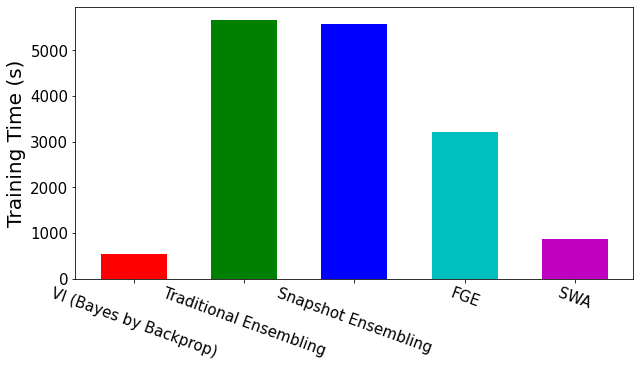

In [ ]:
fs = 20
time_comparison_fig = plt.figure(figsize=(10,5))
training_approach = ['VI (Bayes by Backprop)', 'Traditional Ensembling', 'Snapshot Ensembling', 'FGE', 'SWA']
training_time = [Letraining_time, Ens_Letraining_time, Snap_Ens_Letraining_time, FGE_Letraining_time, SWA_Letraining_time]
color_back = ['r', 'g', 'b', 'c', 'm']

plt.bar(training_approach, training_time, width=0.6, color=color_back)
plt.ylabel('Training Time (s)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.xticks(rotation = 340)
plt.show()

**Accuracy on Testset Comparison**

In [5]:
Leacc = np.load('/content/drive/MyDrive/FGE + SWA/Leacc.npy', allow_pickle=True).item()
Ens_Leacc = np.load('/content/drive/MyDrive/FGE + SWA/Ens_Leacc.npy', allow_pickle=True).item()
Snap_Ens_Leacc = np.load('/content/drive/MyDrive/FGE + SWA/Snap_Ens_Leacc.npy', allow_pickle=True).item()
FGE_Ens_Leacc = np.load('/content/drive/MyDrive/FGE + SWA/FGE_Ens_Leacc.npy', allow_pickle=True).item()
SWA_Ens_Leacc = np.load('/content/drive/MyDrive/FGE + SWA/SWA_Ens_Leacc.npy', allow_pickle=True).item()

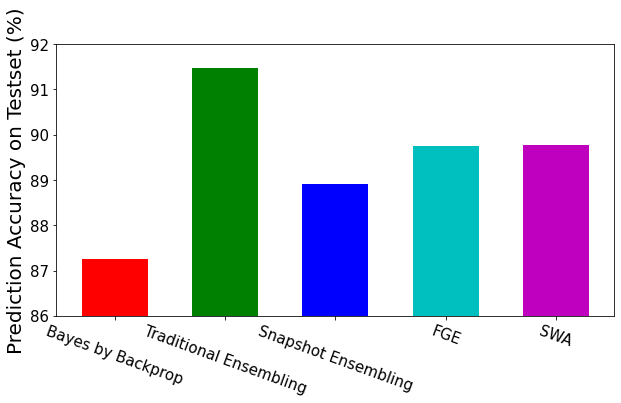

In [ ]:
fs = 20
acc_comparison_fig = plt.figure(figsize=(10,5))
Ensembling = ['Bayes by Backprop', 'Traditional Ensembling', 'Snapshot Ensembling', 'FGE', 'SWA']
acc_testset = [Leacc, Ens_Leacc, Snap_Ens_Leacc, FGE_Ens_Leacc, SWA_Ens_Leacc]
color_back = ['r', 'g', 'b', 'c', 'm']

plt.bar(Ensembling, acc_testset, width=0.6, color=color_back)
plt.ylim(86,92)
plt.ylabel('Prediction Accuracy on Testset (%)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.xticks(rotation = 340)
plt.show()

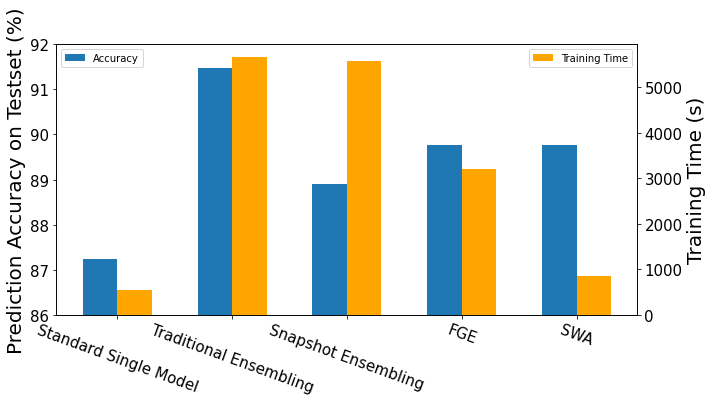

In [6]:
fs = 20
fig_ens_compare, ax1 = plt.subplots(figsize=(10,5.5))
ax1.set_ylabel('Prediction Accuracy on Testset (%)',fontsize=fs)
ax1.set_ylim(86,92)
Ensembling = ['Standard Single Model', 'Traditional Ensembling', 'Snapshot Ensembling', 'FGE', 'SWA']
acc_testset = [Leacc, Ens_Leacc, Snap_Ens_Leacc, FGE_Ens_Leacc, SWA_Ens_Leacc]
ax1.bar(Ensembling, acc_testset, width=-0.3, align='edge', label = 'Accuracy')
ax1.tick_params(labelsize=15)
ax1.set_xticklabels(Ensembling, rotation = 340)

ax1.set_xticklabels(ax1.get_xticklabels())

ax2 = ax1.twinx()
ax2.set_ylabel('Training Time (s)',fontsize=fs)
#ax2.set_ylim()
training_time = [Letraining_time, Ens_Letraining_time, Snap_Ens_Letraining_time, FGE_Letraining_time, SWA_Letraining_time]
ax2.bar(Ensembling, training_time, width=0.3, align='edge', color = 'orange', label = 'Training Time')
ax2.tick_params(labelsize=15)

ax1.legend(loc='upper left')
ax2.legend()
fig_ens_compare.tight_layout()
fig_ens_compare.show()

In [7]:
fig_ens_compare.savefig("fig_ens_compare.png")